# Cifar-10 이미지 분류_v2
- 데이터 부풀림

In [1]:
import tensorflow as tf
import numpy as np
seed = 2022
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

## 데이터 전처리

In [3]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
y_train[0][0]

6

- X_data Scaling

In [8]:
X_train = X_train/255.
X_test = X_test/255.

- y_data One-Hot Encoding

In [9]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

## 모델 정의 및 설정

In [10]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop

In [11]:
model = Sequential([
    Conv2D(32, (3, 3), input_shape = X_train.shape[1:],padding = 'same', activation = 'relu'),
    Conv2D(32, (3, 3), activation = 'relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation = 'softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        36928     
                                                        

In [12]:
model.compile(RMSprop(learning_rate=0.0001, decay = 1e-6), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [13]:
model_path = 'best-cifar10-v2.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience = 10)

### 데이터 부풀리기

In [14]:
from sklearn.model_selection import train_test_split
x_train, X_valid, y_train, Y_valid = train_test_split(
    X_train, Y_train, stratify = Y_train, test_size = 0.2, random_state = seed
)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,          # randomly rotate images in the range 15 degree
    width_shift_range=0.1,      # randomly shift images horizontally 
    height_shift_range=0.1,     # randomly shift images vertically
    shear_range=0.1,            # 도형의 기울기
    zoom_range=[0.8,1.2],       # 0.8~1.2 배 크기로 임의로 확대/축소
    horizontal_flip=True,       # randomly flip images
    vertical_flip=False,        # randomly flip images
    fill_mode='nearest'         # set mode for filling points outside the input boundaries
)

In [16]:
datagen.fit(X_train)

In [17]:
hist = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    validation_data=(X_valid, Y_valid),
    epochs=100, callbacks=[mc, es]
)

Epoch 1/100
1562/1563 [============================>.] - ETA: 0s - loss: 1.8557 - accuracy: 0.3151
Epoch 1: val_loss improved from inf to 1.58115, saving model to best-cifar10-v2.h5
1563/1563 [==============================] - 43s 19ms/step - loss: 1.8555 - accuracy: 0.3153 - val_loss: 1.5811 - val_accuracy: 0.4209
Epoch 2/100
1562/1563 [============================>.] - ETA: 0s - loss: 1.5931 - accuracy: 0.4182
Epoch 2: val_loss improved from 1.58115 to 1.42637, saving model to best-cifar10-v2.h5
1563/1563 [==============================] - 31s 20ms/step - loss: 1.5931 - accuracy: 0.4182 - val_loss: 1.4264 - val_accuracy: 0.4683
Epoch 3/100
1562/1563 [============================>.] - ETA: 0s - loss: 1.4899 - accuracy: 0.4641
Epoch 3: val_loss improved from 1.42637 to 1.33501, saving model to best-cifar10-v2.h5
1563/1563 [==============================] - 30s 19ms/step - loss: 1.4899 - accuracy: 0.4641 - val_loss: 1.3350 - val_accuracy: 0.5271
Epoch 4/100
1562/1563 [==================

In [18]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.6818 - accuracy: 0.7708


[0.68183833360672, 0.770799994468689]

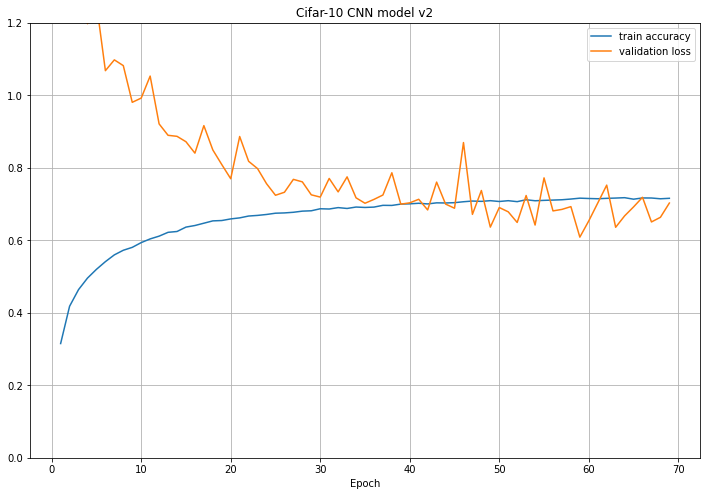

In [19]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.legend(), plt.grid(), plt.ylim(0,1.2),
plt.xlabel('Epoch')
plt.title('Cifar-10 CNN model v2')
plt.show()